# Linear Regression 80/20 train/test split

Results for a 80/20 train/test split:

Feature names and their corresponding weights:
age: -0.03135403260601891
sex: -0.14994192193379874
test_time: -0.04324162917263555
total_UPDRS: 7.263103911273387
Jitter(%): 1.8101184345900503
Jitter(Abs): -2.5035609710425577
Shimmer: 0.16488099270974654
NHR: -0.19392260878634038
HNR: -0.020652542179557587
RPDE: -0.16985463278116897
DFA: 0.18571079720582828
PPE: 0.5997956731617644

Results for train set:
MSE: 6.464663763634765
RMSE: 2.5425703065273857
R^2: 0.8904282121044919

Results for test set:
MSE: 6.8485565521579135
RMSE: 2.6169746945963985
R^2: 0.8689063102004345


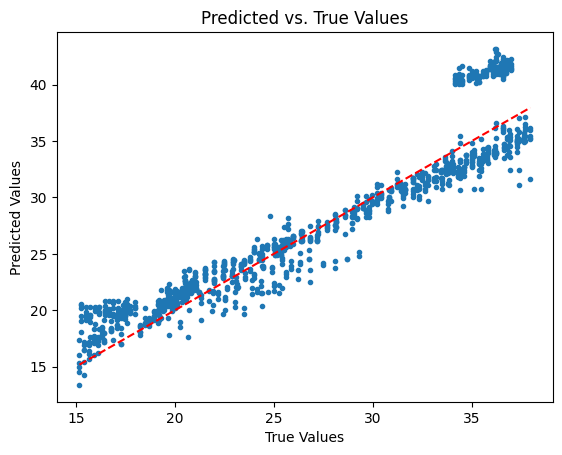

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
split = 80

# fetch dataset
df = pd.read_csv('parkinsons_updrs.csv')
pd.set_option('display.max_columns', None)

# data (as pandas dataframes)
X = df.drop(columns=['motor_UPDRS', 'subject#']) #Features
Y = df[['motor_UPDRS']] #Target

#get correlation matrix
corr = abs(X.corr())
#get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
# find features with correlation greater than 0.9 with each other
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# drop highly correlated features
X = X.drop(to_drop, axis=1)

#drop outliers with z score greater than 3
z = np.abs(stats.zscore(X))
#~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self,x,y):
        if x.ndim == 1:
            x = x[:,None]
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        self.w = np.linalg.lstsq(x,y)[0]
        return self

    def predict(self,x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

#Split Data
train_range = int(split / 100 * len(X))
X_train = X.iloc[:train_range]
X_predict = X.iloc[train_range:]
Y_train = Y.iloc[:train_range]
Y_predict = Y.iloc[train_range:]

#Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_predict = scaler.transform(X_predict)

#Fit and Predict
model = LinearRegression().fit(X_train,Y_train)
yh_train = model.predict(X_train)
yh_test = model.predict(X_predict)

#Cost Function for prediction
mse_test = np.mean((Y_predict - yh_test)**2)
rmse_test = np.sqrt(mse_test)
mse_train = np.mean((Y_train - yh_train)**2)
rmse_train = np.sqrt(mse_train)

def R2(y,yh):
    y = y.values
    y_mean = np.mean(y)
    ss_res = np.sum((y-yh)**2)
    ss_tot = np.sum((y-y_mean)**2)
    return 1 - ss_res / ss_tot

print(f'Results for a {split}/{100-split} train/test split:')
print(f'\nFeature names and their corresponding weights:')
for i, col in enumerate(X.columns):
    print(f"{col}: {model.w[i][0]}")
print('\nResults for train set:')
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"R^2: {R2(Y_train, yh_train)}")
print('\nResults for test set:')
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2: {R2(Y_predict, yh_test)}")

plt.plot(Y_predict,yh_test,'.')
plt.plot([Y_predict.min(), Y_predict.max()],[Y_predict.min(), Y_predict.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.show()

# Logistic Regression (80/20 train/test split with learning rate 0.5)

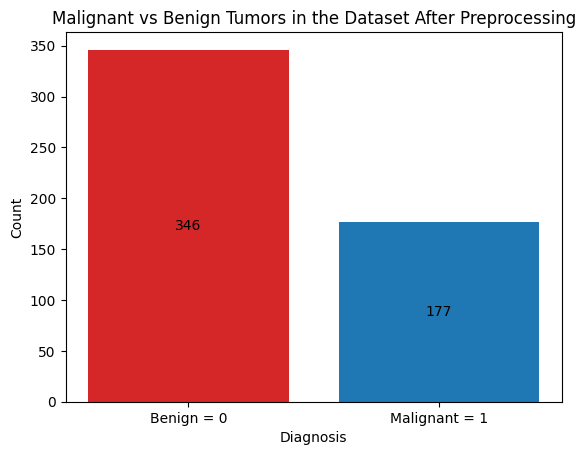


Feature names and their corresponding weights:
radius1: 5.597292766017369
texture1: 1.7737097706383298
smoothness1: 1.6094668241182013
compactness1: -2.5375368168772754
concavity1: 2.069781151708283
symmetry1: 0.2569739083909749
fractal_dimension1: -1.0190702097486717
compactness3: 1.3890098990321156
smoothness3: -0.20590964347673257
area3: 1.0388192869569326
texture3: 0.20058354930717537
radius3: 1.328333305329933


Results for a 80/20 train/test split with learning rate 0.5:
Training set performance:
408/418 correct classifications (97.61% accuracy)
Testing set performance:
99/105 correct classifications (94.29% accuracy)


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit as logistic
import argparse
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

#parse arguments
alpha = 0.5
split = 80

#set headers
wdbcHeaders = ["ID", "Diagnosis"]
features = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"]
for i in range(len(features)):
    wdbcHeaders.insert(i+2, features[i]+"1") #average value of the feature
    wdbcHeaders.insert(2*i+3, features[i]+"2") #standard error of the feature
    wdbcHeaders.insert(2*i+4, features[i]+"3") #worst/largest of the feature

breast_cancer_wisconsin_diagnostic = pd.read_csv('wdbc_diagnosis.csv', header=None, names=wdbcHeaders)
pd.set_option('display.max_columns', None)

X = breast_cancer_wisconsin_diagnostic.drop(columns =['Diagnosis', 'ID']) #features
X = X.drop(X.iloc[:, 10:20], axis=1) #drop standard error features
Y = breast_cancer_wisconsin_diagnostic[['Diagnosis']].copy() #target

# Convert string labels to numeric: 'M' (malignant) = 1, 'B' (benign) = 0
Y['Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})

#get correlation matrix
corr = abs(X.corr())
#get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
#find features with correlation greater than 0.9 with each other
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
#drop highly correlated features
X = X.drop(to_drop, axis=1)

#drop outliers with z score greater than 3
z = np.abs(stats.zscore(X))
#~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

wdbc_bar = plt.bar(['Benign = 0', 'Malignant = 1'], Y.value_counts(), color=['tab:red', 'tab:blue']) #bar chart of diagnosis
plt.title('Malignant vs Benign Tumors in the Dataset After Preprocessing')
plt.xlabel('Diagnosis')
plt.bar_label(wdbc_bar, labels=Y.value_counts(), label_type='center')
plt.ylabel('Count')
plt.show()



class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5, verbose=True):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.verbose = verbose

    def fit(self,x,y):
        #Convert to numpy arrays if necessary
        if hasattr(x, 'values'):
            x = x.values
        if hasattr(y, 'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        #gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iter:
            g = self.gradient(x,y)
            self.w = self.w - self.learning_rate * g
            t += 1

        if self.verbose:
            print(f'\nFeature names and their corresponding weights:')
            for i, col in enumerate(X.columns):
                print(f"{col}: {self.w[i]}")
            print('\n')
        return self

    def predict(self,x):
        if hasattr(x, 'values'):
            x = x.values
        if x.ndim == 1:
            x = x[:,None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = logistic(np.dot(x,self.w))
        grad = np.dot(x.T, yh - y) / N
        return grad

def test_logistic_regression(x, y, split_percent, learning_rate):
    train_range = int(len(x) * split_percent / 100)

    # Split data
    X_train = x.iloc[:train_range]
    X_test = x.iloc[train_range:]
    y_train = y.iloc[:train_range]
    y_test = y.iloc[train_range:]

    #Scale Features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LogisticRegression(learning_rate=learning_rate).fit(X_train, y_train)
    yh_test = model.predict(X_test)
    yh_train = model.predict(X_train)
    ny_test = y_test['Diagnosis'].to_numpy()
    ny_train = y_train['Diagnosis'].to_numpy()

    matching_test = (yh_test.round() == ny_test).sum() #Number of correct classifications
    matching_train = (yh_train.round() == ny_train).sum()
    test_total = len(y_test)
    train_total = len(y_train)

    # Print results
    print(f'Results for a {split}/{100-split} train/test split with learning rate {alpha}:')
    print('Training set performance:')
    print(f'{matching_train}/{train_total} correct classifications ({round(matching_train * 100 / train_total, 2)}% accuracy)')
    print('Testing set performance:')
    print(f'{matching_test}/{test_total} correct classifications ({round(matching_test * 100 / test_total, 2)}% accuracy)')

#run the test using command line arguments
test_logistic_regression(X, Y, split, alpha)


**Stochastic Gradient Descent Linear Regression (80/20 train/test split and batch size 2350 with learning rate 1)**

Results for a 80/20 train/test split and batch size 2214 with learning rate 1:

Feature names and their corresponding weights:
age: -0.014293043144205748
sex: 0.10032537417752826
test_time: -0.0316022793177814
total_UPDRS: 7.271400077641919
Jitter(%): 0.8343244652285812
Jitter(Abs): -1.3900838938014781
Shimmer: 0.22883380358930433
NHR: -0.130127857067983
HNR: -0.014603868336307557
RPDE: -0.30965493848440456
DFA: 0.10453355121487046
PPE: 0.5859295797916838

Results for train set:
MSE: 6.584088029319814
RMSE: 2.5659477838256595
R^2: 0.8884040495513165

Results for test set:
MSE: 6.1824406325450925
RMSE: 2.486451413670714
R^2: 0.8816569669368179


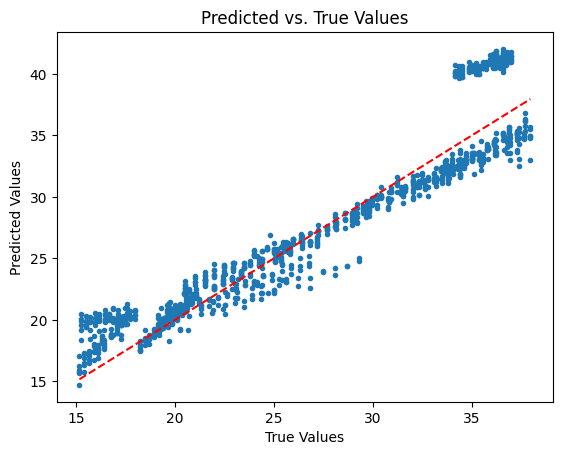

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import argparse
from scipy import stats

split = 80
alpha = 1
batch = 50
batch_size = 0

# fetch dataset
df = pd.read_csv('parkinsons_updrs.csv')
pd.set_option('display.max_columns', None)

# data (as pandas dataframes)
X = df.drop(columns=['motor_UPDRS', 'subject#']) #Features
Y = df[['motor_UPDRS']] #Target

#get correlation matrix
corr = abs(X.corr())
#get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
# find features with correlation greater than 0.9 with each other
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# drop highly correlated features
X = X.drop(to_drop, axis=1)

#drop outliers with z score greater than 3
z = np.abs(stats.zscore(X))
#~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

class LinearRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        pass

    def fit(self,x,y):
        if hasattr(y,'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)

        #gradient descent
        g = np.inf
        t = 1
        global batch_size
        batch_size = int(batch * N / 100) #get batch size
        while np.linalg.norm(g) > self.epsilon and t <= self.max_iter:
            random_indices = np.random.choice(N,size=batch_size,replace=False)
            X_batch = x[random_indices]
            Y_batch = y[random_indices]
            g = self.gradient(X_batch,Y_batch)
            self.w = self.w - self.learning_rate / t * g
            t += 1
        return self

    def predict(self,x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = np.dot(x,self.w)
        grad = np.dot(x.T,(yh - y)) / N
        return grad

#Split Data
train_range = int(split / 100 * len(X))
X_train = X.iloc[:train_range]
X_predict = X.iloc[train_range:]
Y_train = Y.iloc[:train_range]
Y_predict = Y.iloc[train_range:]

#Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_predict = scaler.transform(X_predict)

#Fit and Predict
model = LinearRegression().fit(X_train,Y_train)
yh_train = model.predict(X_train)
yh_test = model.predict(X_predict)

#Cost Function for prediction
mse_test = np.mean((Y_predict.values.flatten() - yh_test)**2)
rmse_test = np.sqrt(mse_test)
mse_train = np.mean((Y_train.values.flatten() - yh_train)**2)
rmse_train = np.sqrt(mse_train)

def R2(y,yh):
    y = y.values.flatten()
    y_mean = np.mean(y)
    ss_res = np.sum((y-yh)**2)
    ss_tot = np.sum((y-y_mean)**2)
    return 1 - ss_res / ss_tot

print(f'Results for a {split}/{100-split} train/test split and batch size {batch_size} with learning rate {alpha}:')
print(f'\nFeature names and their corresponding weights:')
for i, col in enumerate(X.columns):
    print(f"{col}: {model.w[i]}")
print('\nResults for train set:')
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"R^2: {R2(Y_train, yh_train)}")
print('\nResults for test set:')
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2: {R2(Y_predict, yh_test)}")

plt.plot(Y_predict,yh_test,'.')
plt.plot([Y_predict.min(), Y_predict.max()],[Y_predict.min(), Y_predict.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.show()


**Stochastic Gradient Descent Logistic Regression (80/20 train/test split and batch size 209 with learning rate 10)**

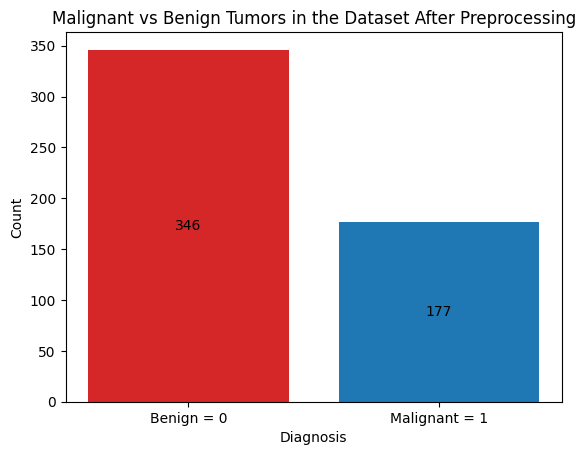


Feature names and their corresponding weights:
radius1: 4.436820746565096
texture1: 2.4190790845381835
smoothness1: 1.0030680066080995
compactness1: 0.24506808424201212
concavity1: 1.973585002987193
symmetry1: 0.026000612296714454
fractal_dimension1: -2.446403157393164
compactness3: 1.9299126771861879
smoothness3: 0.3629827146076853
area3: 1.384324363066771
texture3: 0.7087066977245743
radius3: -0.1306115828859525


Results for a 80/20 train/test split and batch size 209 with learning rate 10:
Training set performance:
404/418 correct classifications (96.65% accuracy)
Testing set performance:
98/105 correct classifications (93.33% accuracy)


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit as logistic
import argparse
from scipy import stats
from sklearn.preprocessing import StandardScaler

split=80
alpha=10
batch=50
batch_size = 0

#set headers
wdbcHeaders = ["ID", "Diagnosis"]
features = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"]
for i in range(len(features)):
    wdbcHeaders.insert(i+2, features[i]+"1") #average value of the feature
    wdbcHeaders.insert(2*i+3, features[i]+"2") #standard error of the feature
    wdbcHeaders.insert(2*i+4, features[i]+"3") #worst/largest of the feature

breast_cancer_wisconsin_diagnostic = pd.read_csv('wdbc_diagnosis.csv', header=None, names=wdbcHeaders)
pd.set_option('display.max_columns', None)

X = breast_cancer_wisconsin_diagnostic.drop(columns =['Diagnosis', 'ID']) #features
X = X.drop(X.iloc[:, 10:20], axis=1) #drop standard error features
Y = breast_cancer_wisconsin_diagnostic[['Diagnosis']].copy() #target

# Convert string labels to numeric: 'M' (malignant) = 1, 'B' (benign) = 0
Y['Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})

#get correlation matrix
corr = abs(X.corr())
#get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
#find features with correlation greater than 0.9 with each other
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
#drop highly correlated features
X = X.drop(to_drop, axis=1)

#drop outliers with z score greater than 3
z = np.abs(stats.zscore(X))
#~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_mask = (z > 3).any(axis=1)
X = X[~outlier_mask]
Y = Y[~outlier_mask]

wdbc_bar = plt.bar(['Benign = 0', 'Malignant = 1'], Y.value_counts(), color=['tab:red', 'tab:blue']) #bar chart of diagnosis
plt.title('Malignant vs Benign Tumors in the Dataset After Preprocessing')
plt.xlabel('Diagnosis')
plt.bar_label(wdbc_bar, labels=Y.value_counts(), label_type='center')
plt.ylabel('Count')
plt.show()

class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5, verbose=True):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.verbose = verbose

    def fit(self,x,y):
        #Convert to numpy arrays if necessary
        if hasattr(x, 'values'):
            x = x.values
        if hasattr(y, 'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 1
        global batch_size
        batch_size = int(batch * N / 100)
        #gradient descent
        while np.linalg.norm(g) > self.epsilon and t <= self.max_iter:
            random_indices = np.random.choice(N,size=batch_size,replace=False)
            X_batch = x[random_indices]
            Y_batch = y[random_indices]
            g = self.gradient(X_batch,Y_batch)
            self.w = self.w - self.learning_rate /t * g
            t += 1

        if self.verbose:
          print(f'\nFeature names and their corresponding weights:')
          for i, col in enumerate(X.columns):
            print(f"{col}: {self.w[i]}")
          print('\n')
        return self

    def predict(self,x):
        if hasattr(x, 'values'):
            x = x.values
        if x.ndim == 1:
            x = x[:,None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = logistic(np.dot(x,self.w))
        grad = np.dot(x.T, yh - y) / N
        return grad

def test_logistic_regression(x, y, split_percent, learning_rate):
    train_range = int(len(x) * split_percent / 100)

    #Split data
    X_train = x.iloc[:train_range]
    X_test = x.iloc[train_range:]
    y_train = y.iloc[:train_range]
    y_test = y.iloc[train_range:]

    #Scale Features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LogisticRegression(learning_rate=learning_rate).fit(X_train, y_train)
    yh_test = model.predict(X_test)
    yh_train = model.predict(X_train)
    ny_test = y_test['Diagnosis'].to_numpy()
    ny_train = y_train['Diagnosis'].to_numpy()

    matching_test = (yh_test.round() == ny_test).sum() #Number of correct classifications
    matching_train = (yh_train.round() == ny_train).sum()
    test_total = len(y_test)
    train_total = len(y_train)

    # Print results
    print(f'Results for a {split}/{100-split} train/test split and batch size {batch_size} with learning rate {alpha}:')
    print('Training set performance:')
    print(f'{matching_train}/{train_total} correct classifications ({round(matching_train * 100 / train_total, 2)}% accuracy)')
    print('Testing set performance:')
    print(f'{matching_test}/{test_total} correct classifications ({round(matching_test * 100 / test_total, 2)}% accuracy)')
#run the test using command line arguments
test_logistic_regression(X, Y, split, alpha)

#Correlation matrix for logistic regression dataset + distribution of target

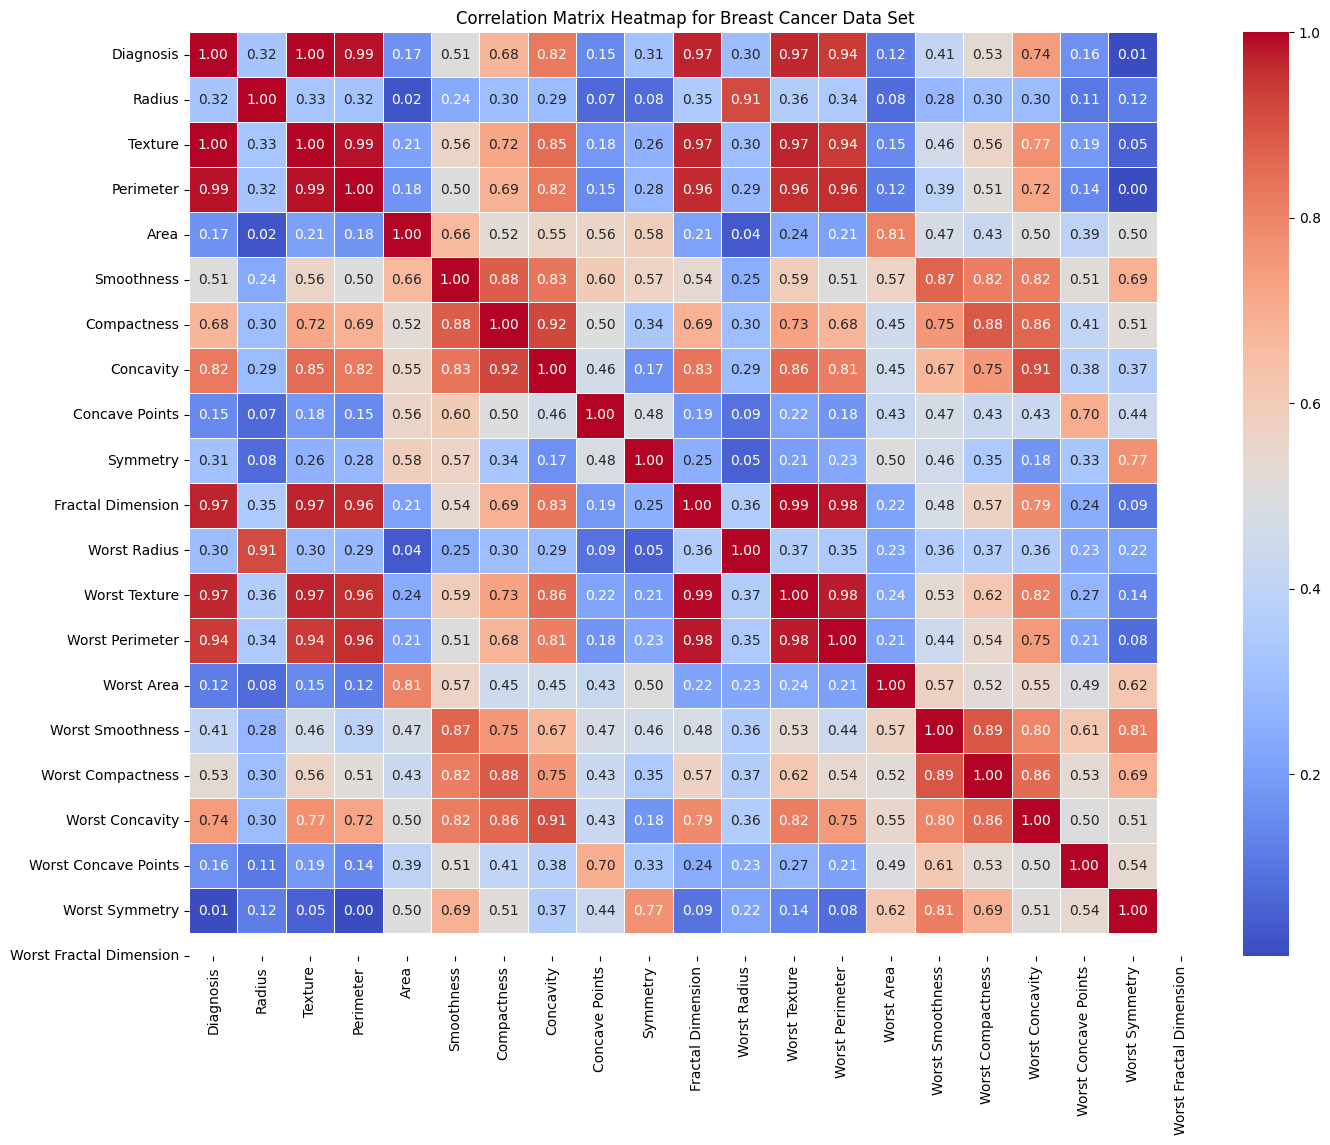

Number of outlier instances dropped from Breast Cancer Data Set: 82


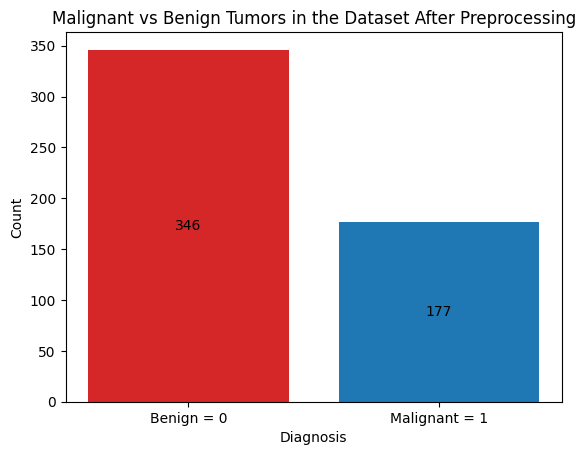

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit as logistic
import argparse
import seaborn as sns
from scipy import stats

split=80
alpha=10
batch=50
batch_size = 0

#set headers
wdbcHeaders = ["ID", "Diagnosis"]
features = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"]
for i in range(len(features)):
    wdbcHeaders.insert(i+2, features[i]+"1") #average value of the feature
    wdbcHeaders.insert(2*i+3, features[i]+"2") #standard error of the feature
    wdbcHeaders.insert(2*i+4, features[i]+"3") #worst/largest of the feature

breast_cancer_wisconsin_diagnostic = pd.read_csv('wdbc_diagnosis.csv', header=None, names=wdbcHeaders)
pd.set_option('display.max_columns', None)

X = breast_cancer_wisconsin_diagnostic.drop(columns =['Diagnosis', 'ID']) #features
X = X.drop(X.iloc[:, 10:20], axis=1) #drop standard error features
Y = breast_cancer_wisconsin_diagnostic[['Diagnosis']].copy() #target

# Convert string labels to numeric: 'M' (malignant) = 1, 'B' (benign) = 0
Y['Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})

#get correlation matrix
corr = abs(X.corr())

#plot correlation matrix
plt.figure(figsize=(16,12))
plt.title('Correlation Matrix Heatmap for Breast Cancer Data Set')
sns.heatmap(corr, #plot heatmap for correlation matrix of mean variables for this dataset
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5,
            xticklabels= ['Diagnosis', 'Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', "Concavity", "Concave Points", "Symmetry", "Fractal Dimension", "Worst Radius", 'Worst Texture', 'Worst Perimeter', 'Worst Area', 'Worst Smoothness', 'Worst Compactness', "Worst Concavity", "Worst Concave Points", "Worst Symmetry", "Worst Fractal Dimension"],
            yticklabels= ['Diagnosis', 'Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', "Concavity", "Concave Points", "Symmetry", "Fractal Dimension", "Worst Radius", 'Worst Texture', 'Worst Perimeter', 'Worst Area', 'Worst Smoothness', 'Worst Compactness', "Worst Concavity", "Worst Concave Points", "Worst Symmetry", "Worst Fractal Dimension"]
            )
plt.show()

#get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
#find features with correlation greater than 0.9 with each other
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
#drop highly correlated features
X = X.drop(to_drop, axis=1)

#drop outliers with z score greater than 3
z = np.abs(stats.zscore(X))
#~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_mask = (z > 3).any(axis=1)
print("Number of outlier instances dropped from Breast Cancer Data Set: " + str(len(np.where(z > 3)[0])))
X = X[~outlier_mask]
Y = Y[~outlier_mask]

wdbc_bar = plt.bar(['Benign = 0', 'Malignant = 1'], Y.value_counts(), color=['tab:red', 'tab:blue']) #bar chart of diagnosis
plt.title('Malignant vs Benign Tumors in the Dataset After Preprocessing')
plt.xlabel('Diagnosis')
plt.bar_label(wdbc_bar, labels=Y.value_counts(), label_type='center')
plt.ylabel('Count')
plt.show()



#Correlation matrix for linear regression dataset + distribution of target

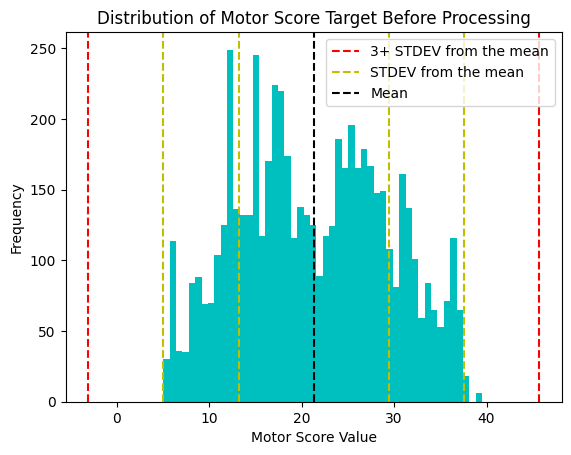

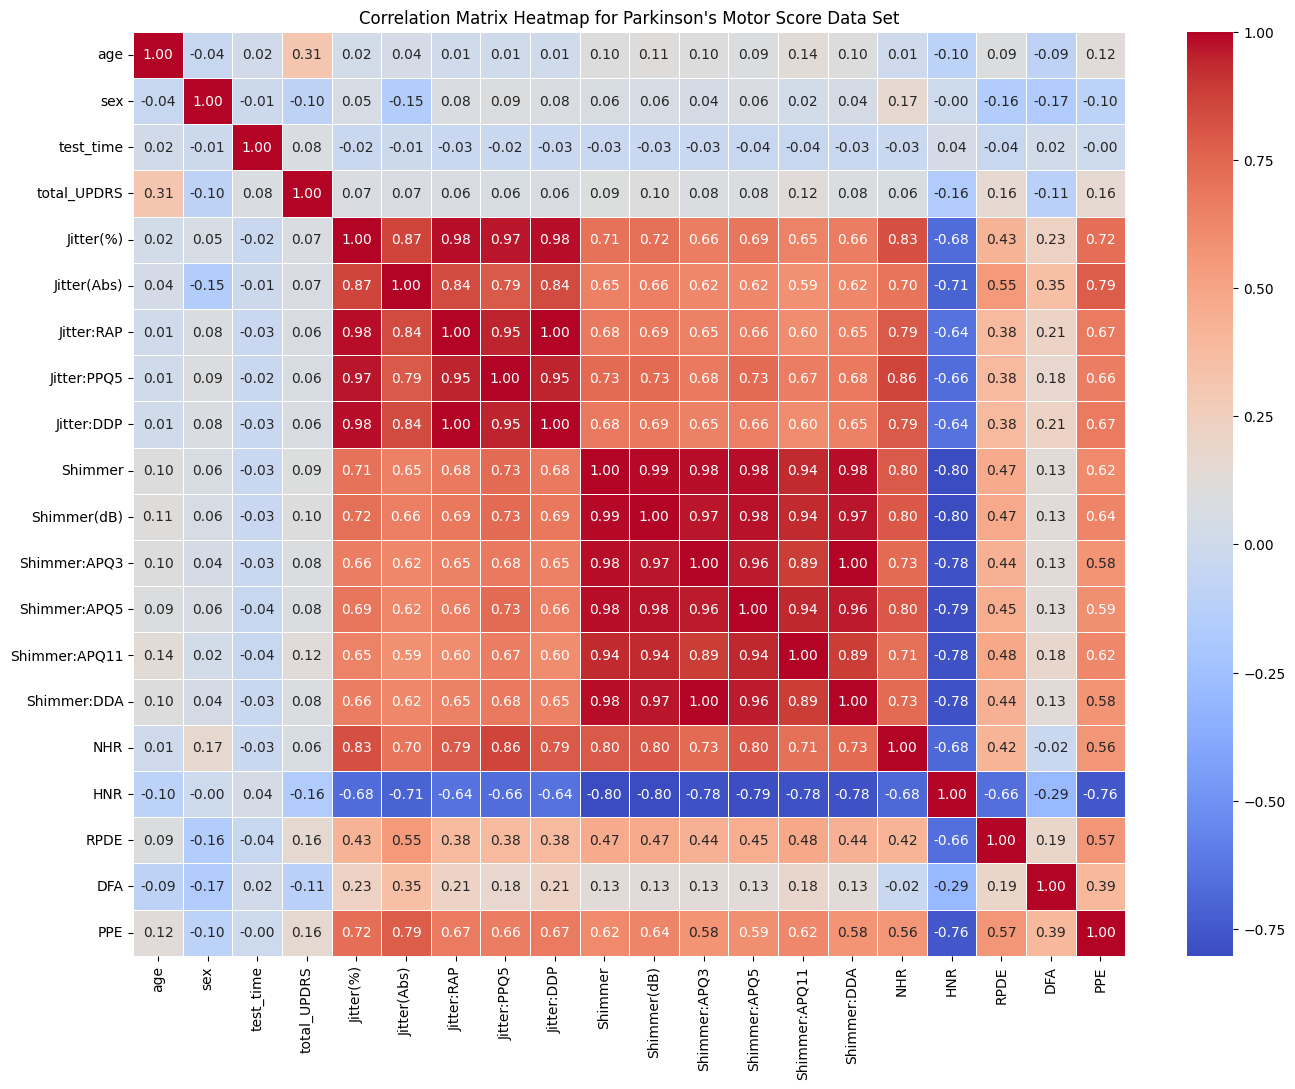

Number of outlier instances dropped from Parkinson's Data Set: 774


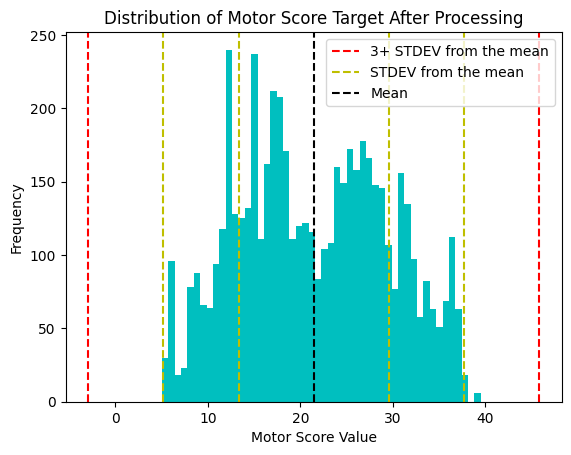

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
split = 80

# fetch dataset
df = pd.read_csv('parkinsons_updrs.csv')
pd.set_option('display.max_columns', None)

# data (as pandas dataframes)
X = df.drop(columns=['motor_UPDRS', 'subject#']) #Features
Y = df[['motor_UPDRS']] #Target

#create plot of distribution of the target before processing
avg = Y.mean(axis=0).iloc[0]
sd = Y.std(axis=0).iloc[0]
plt.hist(Y, color='c', bins = 50)
plt.axvline(avg-3*sd, linestyle='dashed', color ='r', label = "3+ STDEV from the mean")
plt.axvline(avg-2*sd, linestyle='dashed', color = 'y', label = "STDEV from the mean")
plt.axvline(avg-sd, linestyle='dashed', color = 'y')
plt.axvline(avg, linestyle='dashed', color = 'k', label = "Mean")
plt.axvline(avg+sd, linestyle='dashed', color = 'y')
plt.axvline(avg+2*sd, linestyle='dashed', color = 'y')
plt.axvline(avg+3*sd, linestyle='dashed', color ='r')
plt.title("Distribution of Motor Score Target Before Processing")
plt.legend()
plt.xlabel("Motor Score Value")
plt.ylabel("Frequency")
plt.show()


#get correlation matrix
corr = abs(X.corr())

plt.figure(figsize=(16,12))
plt.title("Correlation Matrix Heatmap for Parkinson's Motor Score Data Set")
sns.heatmap(X.corr(), #plot heatmap for correlation matrix of mean variables for this dataset
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5,
            )
plt.show()

#get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
# find features with correlation greater than 0.9 with each other
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# drop highly correlated features
X = X.drop(to_drop, axis=1)

#drop outliers with z score greater than 3
z = np.abs(stats.zscore(X))
#~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
print("Number of outlier instances dropped from Parkinson's Data Set: " + str(len(outlier_indices)))
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

#create box plot of distribution of the target after processing
avg = Y.mean(axis=0).iloc[0]
sd = Y.std(axis=0).iloc[0]
plt.hist(Y, color='c', bins = 50)
plt.axvline(avg-3*sd, linestyle='dashed', color ='r', label = "3+ STDEV from the mean")
plt.axvline(avg-2*sd, linestyle='dashed', color = 'y', label = "STDEV from the mean")
plt.axvline(avg-sd, linestyle='dashed', color = 'y')
plt.axvline(avg, linestyle='dashed', color = 'k', label = "Mean")
plt.axvline(avg+sd, linestyle='dashed', color = 'y')
plt.axvline(avg+2*sd, linestyle='dashed', color = 'y')
plt.axvline(avg+3*sd, linestyle='dashed', color ='r')
plt.title("Distribution of Motor Score Target After Processing")
plt.xlabel("Motor Score Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()



# Stochastic linear regression changing train/test splits

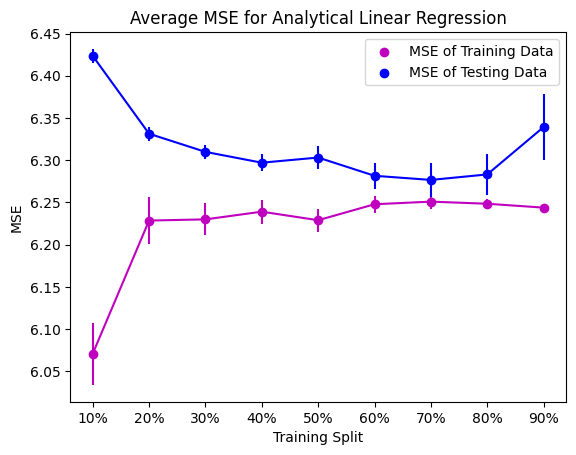

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import argparse
from scipy import stats
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# fetch dataset
df = pd.read_csv('parkinsons_updrs.csv')
pd.set_option('display.max_columns', None)

# data (as pandas dataframes)
X = df.drop(columns=['motor_UPDRS', 'subject#']) #Features
Y = df[['motor_UPDRS']] #Target

#get correlation matrix
corr = abs(X.corr())
#get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
# find features with correlation greater than 0.9 with each other
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# drop highly correlated features
X = X.drop(to_drop, axis=1)

#drop outliers with z score greater than 3
z = np.abs(stats.zscore(X))
#~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self,x,y):
        if x.ndim == 1:
            x = x[:,None]
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        self.w = np.linalg.lstsq(x,y)[0]
        return self

    def predict(self,x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh


def R2(y,yh):
    y = y.values
    y_mean = np.mean(y)
    ss_res = np.sum((y-yh)**2)
    ss_tot = np.sum((y-y_mean)**2)
    return 1 - ss_res / ss_tot

testsplits = np.arange(0.1, 1.0, 0.1)
test_no = 100
MSE_ex3_train = []
MSE_ex3_test = []
for split in testsplits: #go through each split
    for i in range(test_no): #repeat ten time for each split to get error and average value
        #split the data
        X_train, X_predict, Y_train, Y_predict = train_test_split(X, Y, train_size=split)

        #scale the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_predict = scaler.transform(X_predict)

        model = LinearRegression().fit(X_train,Y_train)
        yh_train = model.predict(X_train)
        yh_predict = model.predict(X_predict)

        MSE_train = mean_squared_error(yh_train, Y_train)
        MSE_predict = mean_squared_error(yh_predict, Y_predict)
        MSE_ex3_train.append(round(MSE_train,2))
        MSE_ex3_test.append(round(MSE_predict,2))

avg_MSE_ex3_train = []
avg_MSE_ex3_test = []
err_MSE_ex3_train = []
err_MSE_ex3_test = []
for i in range(len(testsplits)):
    #index only the results of one training split
    train = MSE_ex3_train[i*test_no:(i+1)*test_no]
    test = MSE_ex3_test[i*test_no:(i+1)*test_no]
    #calculate average MSE and error on MSE across the ten tests
    avg_MSE_ex3_train.append(statistics.mean(train))
    avg_MSE_ex3_test.append(statistics.mean(test))
    err_MSE_ex3_train.append(stats.sem(train))
    err_MSE_ex3_test.append(stats.sem(test))

plt.title("Average MSE for Analytical Linear Regression")
plt.errorbar(testsplits, avg_MSE_ex3_train, yerr=err_MSE_ex3_train, color='m')
plt.scatter(testsplits, avg_MSE_ex3_train, label="MSE of Training Data", color='m')
plt.errorbar(testsplits, avg_MSE_ex3_test, yerr=err_MSE_ex3_test, color='b')
plt.scatter(testsplits, avg_MSE_ex3_test , label="MSE of Testing Data", color = 'b')
plt.legend(loc="upper right")
plt.xlabel("Training Split")
plt.xticks(testsplits, labels=['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])
plt.ylabel("MSE")
plt.show()

#Fully-batched logistic regression changing train/test splits

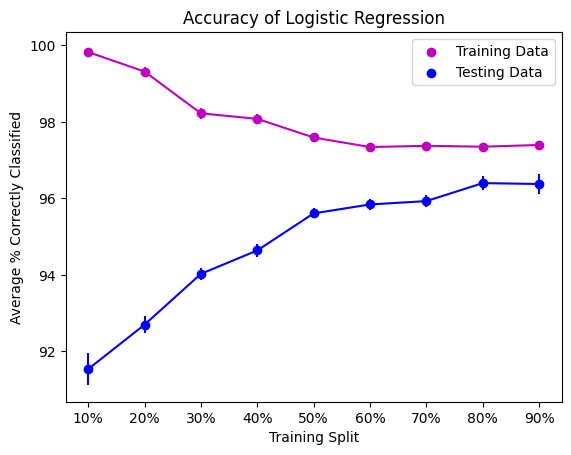

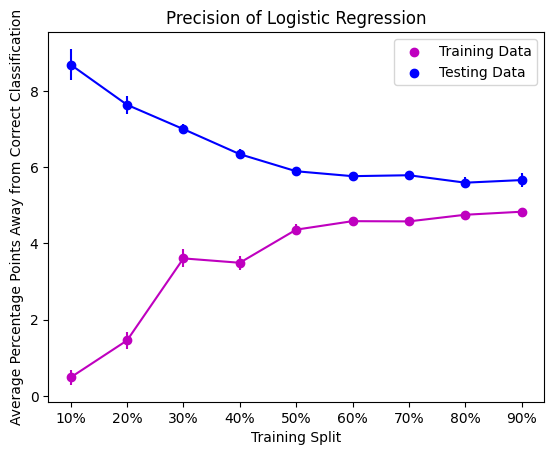

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit as logistic
import argparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
import statistics
from sklearn.preprocessing import StandardScaler

batch_size = 0

#set headers
wdbcHeaders = ["ID", "Diagnosis"]
features = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"]
for i in range(len(features)):
    wdbcHeaders.insert(i+2, features[i]+"1") #average value of the feature
    wdbcHeaders.insert(2*i+3, features[i]+"2") #standard error of the feature
    wdbcHeaders.insert(2*i+4, features[i]+"3") #worst/largest of the feature

breast_cancer_wisconsin_diagnostic = pd.read_csv('wdbc_diagnosis.csv', header=None, names=wdbcHeaders)
pd.set_option('display.max_columns', None)

X = breast_cancer_wisconsin_diagnostic.drop(columns =['Diagnosis', 'ID']) #features
X = X.drop(X.iloc[:, 10:20], axis=1) #drop standard error features
Y = breast_cancer_wisconsin_diagnostic[['Diagnosis']].copy() #target

# Convert string labels to numeric: 'M' (malignant) = 1, 'B' (benign) = 0
Y['Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})

#get correlation matrix
corr = abs(X.corr())
#get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
#find features with correlation greater than 0.9 with each other
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
#drop highly correlated features
X = X.drop(to_drop, axis=1)

#drop outliers with z score greater than 3
z = np.abs(stats.zscore(X))
#~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5, verbose=True):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.verbose = verbose

    def fit(self,x,y):
        #Convert to numpy arrays if necessary
        if hasattr(x, 'values'):
            x = x.values
        if hasattr(y, 'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        #gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iter:
            g = self.gradient(x,y)
            self.w = self.w - self.learning_rate * g
            t += 1

        if self.verbose:
            #print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'\nFeature names and their corresponding weights:')
            for i, col in enumerate(X.columns):
                print(f"{col}: {self.w[i]}")
            print('\n')

        return self

    def predict(self,x):
        if hasattr(x, 'values'):
            x = x.values
        if x.ndim == 1:
            x = x[:,None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = logistic(np.dot(x,self.w))
        grad = np.dot(x.T, yh - y) / N
        return grad

testsplits = np.arange(0.1, 1.0, 0.1)
test_no = 100
pct_ex3_train = []
pct_ex3_test = []
precision_ex3_train = []
precision_ex3_test = []
for split in testsplits: #go through each split
    for i in range(test_no): #repeat x times for each split to get error and average value
        #split the data
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=split)

        #scale the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        #initialize the model, train it, predict values
        model = LogisticRegression(verbose=False).fit(X_train,Y_train)
        yh_test = model.predict(X_test)
        yh_train = model.predict(X_train)
        ny_test = Y_test['Diagnosis'].to_numpy()
        ny_train = Y_train['Diagnosis'].to_numpy()

        #calculate results
        matching_test = (yh_test.round() == ny_test).sum() #Number of correct classifications
        matching_train = (yh_train.round() == ny_train).sum()
        test_total = len(Y_test)
        train_total = len(Y_train)
        distance_test = abs(yh_test - ny_test).sum()
        distance_train = abs(yh_train - ny_train).sum()

        #store results for processing
        pct_ex3_train.append(round(matching_train/train_total*100, 2)) #rate of correct classification (accuracy)
        pct_ex3_test.append(round(matching_test/test_total*100, 2))
        precision_ex3_train.append(round(distance_train/train_total*100, 2)) #distance from correct classification as pct pts(precision)
        precision_ex3_test.append(round(distance_test/test_total*100, 2))

avg_pct_ex3_train = []
avg_pct_ex3_test = []
err_pct_ex3_train = []
err_pct_ex3_test = []

avg_precision_ex3_train = []
avg_precision_ex3_test = []
err_precision_ex3_train = []
err_precision_ex3_test = []

for i in range(len(testsplits)):
    #index only the results of one training split
    train_acc = pct_ex3_train[i*test_no:(i+1)*test_no]
    test_acc = pct_ex3_test[i*test_no:(i+1)*test_no]
    train_pre = precision_ex3_train[i*test_no:(i+1)*test_no]
    test_pre = precision_ex3_test[i*test_no:(i+1)*test_no]

    #calculate average and error on precision and accuracy across the x tests
    avg_pct_ex3_train.append(statistics.mean(train_acc))
    avg_pct_ex3_test.append(statistics.mean(test_acc))
    err_pct_ex3_train.append(stats.sem(train_acc))
    err_pct_ex3_test.append(stats.sem(test_acc))
    avg_precision_ex3_train.append(statistics.mean(train_pre))
    avg_precision_ex3_test.append(statistics.mean(test_pre))
    err_precision_ex3_train.append(stats.sem(train_pre))
    err_precision_ex3_test.append(stats.sem(test_pre))

#plot graph for accuracy
plt.title("Accuracy of Logistic Regression")
plt.errorbar(testsplits, avg_pct_ex3_train, yerr=err_pct_ex3_train, color='m')
plt.scatter(testsplits, avg_pct_ex3_train, label="Training Data", color='m')
plt.errorbar(testsplits, avg_pct_ex3_test, yerr=err_pct_ex3_test, color='b')
plt.scatter(testsplits, avg_pct_ex3_test , label="Testing Data", color = 'b')
plt.legend(loc="upper right")
plt.xlabel("Training Split")
plt.xticks(testsplits, labels=['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])
plt.ylabel("Average % Correctly Classified")
plt.show()

#plot graph for precision
plt.title("Precision of Logistic Regression")
plt.errorbar(testsplits, avg_precision_ex3_train, yerr=err_precision_ex3_train, color='m')
plt.scatter(testsplits, avg_precision_ex3_train, label="Training Data", color='m')
plt.errorbar(testsplits, avg_precision_ex3_test, yerr=err_precision_ex3_test, color='b')
plt.scatter(testsplits, avg_precision_ex3_test , label="Testing Data", color = 'b')
plt.legend(loc="upper right")
plt.xlabel("Training Split")
plt.xticks(testsplits, labels=['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])
plt.ylabel("Average Percentage Points Away from Correct Classification")
plt.show()
